# Data explorer for NWIS datat
NWIS is the National Water Information System, with data on surface and groundwater in the USA.
This notebook uses data delivered in a sort of standardized tab-delimited text format 'rdb'.  
Documentation for the format is at 
https://waterdata.usgs.gov/nwis/?tab_delimited_format_info  
and   
https://pubs.usgs.gov/of/2003/ofr03123/6.4rdb_format.pdf  
updates: https://help.waterdata.usgs.gov/news/June-10-2016  

Actual data (see the example URLs included below in one of the cells) shows some variability in conformance to the spec, and also probably reflect evolution of the spec over time.

Important pattern is header in the text file with lines beginning with '#' character; 

* Header:  
The header section contains zero or more lines with information such as disclaimers, sites, parameter and location names. 
The header comment lines start with a sharp sign (#) followed by (one or more...) space character followed by any text desired.

* Column-name row:  
The header is followed by exactly one tab-delimited column-name row. The fields in the tab-delimited column-name row contain the names of each column.

* Column definition row:  
This is followed by exactly one column-definition row.  The fields in the tab-delimited column-definition row contain the data definitions and optional column documentation for each column.

* Data section:  
Then is the data section consisting of any number of rows of tab-delimited data fields. Data rows must have exactly the same number of tab-delimited columns as both the column-name and column-definition rows. Null data values are allowed. 

NWIS data urls are like https://nwis.waterdata.usgs.gov/{state}/nwis/{dataseries}?site_no={siteIDstring}
the {state} part of the host name is optional, can be left out when site_no is provided; it uses standard two character state-name abbreviations (e.g. md, ca, nv...)
{dataseries} is a string identifying NWIS data categories. I haven't found a definitive list, but these are the ones I've figured out:
    * uv -- current data 
    * gwlevels -- groundwater levels
    * peak -- peak stream flow at gage
    * inventory -- site information
    * measurements -- streamflow data for site; https://help.waterdata.usgs.gov/output-formats#streamflow_measurement_data. data files do not include the variable names in header
    
This notebook takes an NWIS site_no as the URL parameter, and determines what data are available for the site from 


In [1]:
#imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import urllib.request
import json
#import urllib
import helpers
import sys
from datetime import datetime, date, time
from ipywidgets import widgets  
from IPython import get_ipython
from IPython.display import display
from matplotlib import pylab
from pylab import *
from IPython.display import clear_output
import warnings

# Utility functions

In [2]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [3]:
def getmetavalue(rdbdata, label,skipVal=-1):
    '''
    function to look for a text string in a text string
    input is a list of text string; 
    searches each string for string containing the 'label' string
    returns the following text, with '- ' and leading/trailing spaces removed
    .
    '''
    inlabel=''
    #first have to handle column names that are parameter numbers
    if label.split('_')[0].isnumeric():
        inlabel=label
        label = label.split('_')[0]

    
    rowcount=0
#    for line in rdbdata:
#        rowcount=rowcount+1
#    print('file lines: ' + str(rowcount))
#    return('nothing')
#    print('getmetadatavalue for ' + label)
    for line in rdbdata:
        strline = str(line)
        #print('line:' + strline)
        if (label in strline):
            out= strline.split(label)[1]
            out = out.strip()
            if (strline[1:2]=='- '):
                out = strline.split('- ')[1]
            if (len(inlabel) == 0):
                return(out)
            else:
                if (inlabel[-3:]=='_cd'):
                    return(out+' code')
                else:
                    return(out)
        rowcount=rowcount+1
        if (skipVal > 0 and rowcount>skipVal): 
            return('Field not documemented')
    return('Field not documemented')



# Prepare Data:

In [6]:
%%javascript
function getQueryStringValue (key){  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("dataurl='".concat(getQueryStringValue("dataurl")).concat("'"));

IPython.notebook.kernel.execute("site_no='".concat(getQueryStringValue("site_no")).concat("'"));
//get the URL parameters and pass to python

<IPython.core.display.Javascript object>

In [7]:
# Some example URLS included here for various NWIS data

if (len(dataurl)==0):
    print('No URL paramteter')
    # for testing without URL parameter
    
    # Water Quality Samples for the Nation
    dataurl = 'https://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=07373420&format=rdb'
    #dataurl = 'https://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=07373420&pm_cd_compare=Greater%20than&format=rdb'
    site_no='07373420'
    
    # groundwater levels
    #dataurl = 'http://nwis.waterdata.usgs.gov/pa/nwis/gwlevels?site_no=400650075514001&agency_cd=USGS&format=rdb'
    # note this gets same result (no '/pa' in URL):
    #dataurl = 'https://nwis.waterdata.usgs.gov/nwis/gwlevels?site_no=400650075514001&agency_cd=USGS&format=rdb'
    #site_no='400650075514001'
    
    # current conditions
    #dataurl = 'https://waterdata.usgs.gov/nwis/uv/?site_no=06191000&format=rdb'
    #site_no='06191000'
    
    #peak stream flow service
    #dataurl = 'https://nwis.waterdata.usgs.gov/nwis/peak/?site_no=01063310&agency_cd=USGS&format=rdb'
    #site_no='01063310'
    
    #site information:
    #dataurl = 'https://waterdata.usgs.gov/nwis/inventory/?site_no=06022500&format=rdb'
    #site_no='06022500'
    

    # site measurements, rdb expanded, works in most cases but doesn't always add more columns:
    #dataurl = 'https://waterdata.usgs.gov/nwis/measurements?site_no=08158810&format=rdb_expanded'
    #site_no='08158810'
    

else:
    dataurl= dataurl + '&agency_cd=USGS&format=rdb'

No URL paramteter


In [8]:
# Get the data

print(dataurl)
print('Downloading the dataset. Please wait...')

data = urllib.request.urlopen(dataurl) # it's a file like object and works just like a file
# counter for the number of comment lines at the top of the file
skipVal = 0
datalist=[]
for line in data:
    strline = str(line)
    strline = strline.replace("\\r",'')
    strline = strline.replace("\\n",'')
    strline = strline.replace("\'",'')
    #print('line:' + strline)
    if '#' in strline:
        if (strline.find(site_no)>-1):
            site_label=(strline.split('# ')[1].strip())
            #remove extra internal spaces
            site_label = " ".join(site_label.split())
        #print(strline.split('#')[1].strip())
        if (len(strline.split('#')[1].strip()) > 0): 
            out = strline.split('#')[1].strip()
            out = " ".join(out.split())
            #print('output to datalist: ' + out)
            datalist.append(out)
    else:
        break
    skipVal = skipVal + 1
print('Rows to skip: ' + str(skipVal))
global df
df = pd.read_csv(dataurl, sep='\t',skiprows=range(0, skipVal),encoding='utf-8')

#first row is formatting information, save for later
formats = df.head(1)
#print('formats: ' + str(formats))
#print(str(formats['agency_cd'][0]))
#drop the formatting information row
df = df.drop(df.index[0])
#print(df.info)
print('Ready')

https://nwis.waterdata.usgs.gov/usa/nwis/qwdata/?site_no=07373420&format=rdb
Rows to skip: 1408
Ready


E:\EPrograms\Anaconda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,4,5,10,11,12,14,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.dtypes

agency_cd                     object
site_no                       object
sample_dt                     object
sample_tm                     object
sample_end_dt                 object
sample_end_tm                 object
sample_start_time_datum_cd    object
tm_datum_rlbty_cd             object
coll_ent_cd                   object
medium_cd                     object
tu_id                         object
body_part_id                  object
parm_cd                       object
remark_cd                     object
result_va                     object
val_qual_tx                   object
meth_cd                       object
dqi_cd                        object
rpt_lev_va                    object
rpt_lev_cd                    object
lab_std_va                    object
anl_ent_cd                    object
dtype: object

In [10]:
# some data introspection

fielddescriptions={}

for col in df.columns:
    mdstring = getmetavalue(datalist, str(col))
    datatype='nan'
    #print('field: ' + str(col) + '. '+ mdstring + '. Format: ' + str(formats[col][0]) )
    if (col[-3:]=='_cd'):
        datatype='code'
    elif (str(formats[col][0])[-1:]=='s'):
        for item in df[col].tolist():
            #print(str(item)+' type ' + str(type(item)))
            if str(item).isnumeric():
                #print('isnumeric')
                datatype='pinteger'
            elif (str(item)!='nan' and is_number(str(item))):
                #print('float')
                datatype='float'
            elif (str(item)!='nan'):
                #print('string')
                datatype='string'
                
    elif (str(formats[col][0])[-1:]=='d'):
        datatype='date'
    elif (str(formats[col][0])[-1:]=='n'):
        datatype='float'
    else:
        datatype='string'
    
    fielddescriptions[col] = {'desc':mdstring, 
                              'format':str(formats[col][0]),
                             'type':datatype}    
    print(col, fielddescriptions[col])

agency_cd {'desc': '- Agency Code', 'format': '5s', 'type': 'code'}
site_no {'desc': '- USGS site number', 'format': '15s', 'type': 'pinteger'}
sample_dt {'desc': '- Begin date', 'format': '10d', 'type': 'date'}
sample_tm {'desc': '- Begin time', 'format': '5d', 'type': 'date'}
sample_end_dt {'desc': '- End date', 'format': '10d', 'type': 'date'}
sample_end_tm {'desc': '- End time', 'format': '5d', 'type': 'date'}
sample_start_time_datum_cd {'desc': '- Time datum', 'format': '3s', 'type': 'code'}
tm_datum_rlbty_cd {'desc': '- Time datum reliability code', 'format': '1s', 'type': 'code'}
coll_ent_cd {'desc': '- Agency Collecting Sample Code', 'format': '8s', 'type': 'code'}
medium_cd {'desc': '- Sample Medium Code', 'format': '3s', 'type': 'code'}
tu_id {'desc': '- Taxonomic unit code', 'format': '11s', 'type': 'nan'}
body_part_id {'desc': '- Body part code', 'format': '11s', 'type': 'nan'}
parm_cd {'desc': '- Parameter code', 'format': '5s', 'type': 'code'}
remark_cd {'desc': '- Remark

# Graph time series:

In [11]:
df.iloc[0]
#pd.DataFrame(df.count()).transpose().style

#reformat strings to dates  TBD: look for column names ending in '_dt' and work on those
datefields=["Choose Field"]
for col in df.columns:
    if (col[-3:] == '_dt'):
        print(col)
        df[col] =  pd.to_datetime(df[col], format='%Y-%m-%d', errors='ignore')
        datefields.append(col)

display("Number of values in each column",pd.DataFrame(df.count()).transpose().style)


sample_dt
sample_end_dt


'Number of values in each column'

,agency_cd,site_no,sample_dt,sample_tm,sample_end_dt,sample_end_tm,sample_start_time_datum_cd,tm_datum_rlbty_cd,coll_ent_cd,medium_cd,tu_id,body_part_id,parm_cd,remark_cd,result_va,val_qual_tx,meth_cd,dqi_cd,rpt_lev_va,rpt_lev_cd,lab_std_va,anl_ent_cd
0,114894,114894,114894,104345,10463,0,114894,114894,71930,114894,0,0,114893,44797,113084,8639,72329,114893,40624,40624,0,41165


In [12]:
#datefields = np.insert(datefields,0,"Choose Field")
print(datefields)
# pick the time axis variable, use the date fields
#select x axis
pickx = widgets.Dropdown(
    options=datefields,
    description='Date field for X axis:',
    disabled=False,
    value = 'Choose Field'
)

xaxisfield=''

#Describe what happens when the button changes its value
def on_change_x(change):
    global xaxisfield
    if change['type'] == 'change' and change['name'] == 'value':
        print('change: ' + str(change['new']))
        xaxisfield=change['new']
    return
    
pickx.observe(on_change_x)
display(pickx) 

['Choose Field', 'sample_dt', 'sample_end_dt']


Dropdown(description='Date field for X axis:', options=('Choose Field', 'sample_dt', 'sample_end_dt'), value='…

change: sample_dt


In [13]:
# set up variable options for Y

numfields=["Choose Variable:"]  # this will be the prompt in the drop down box
for col in df.columns:
    if (fielddescriptions[col]['type'] == 'float' 
      or fielddescriptions[col]['type'] == 'pinteger'):
      numfields.append(col+'| '+fielddescriptions[col]['desc']) 
    # CHECK if there is a parameters field, for soft-typed result values
if ('parm_cd' in df.columns.values and 'result_va' in df.columns.values):
    for aparam in df['parm_cd'].unique():
        try:
            mdstring = getmetavalue(datalist, str(aparam))
            numfields.append(str(aparam) + '| ' + mdstring)
        except:
            print('did not find name for parameter ' + str(aparam))
    numfields.remove('result_va| '+fielddescriptions['result_va']['desc'])
        
#print(numfields)
#column_values = df.columns.values
#print(df.columns.values)


#handler if have parameter values as key-value pairs
#for index,value in enumerate(column_values):
    #print ('index: %s, value %s' % (index, value))
    #print('col: ' + value + ' Values:' + column_values[index])
    #column_values[index] = "%s %s"%(column_values[index], df['parm_nm'][df['parm_cd'] == value[1:]])
#column_values = np.insert(column_values,0,'Choose Variable')
#column_values

#select x axis
picky = widgets.Dropdown(
    options=numfields,
    description='Numeric field:',
    disabled=False,
    value = 'Choose Variable:'
)

yaxisfield=''

#Describe what happens when the button changes its value
def on_change_y(change):
    global yaxisfield
    if change['type'] == 'change' and change['name'] == 'value':
        #print('change: ' + str(change['new']))
        yaxisfield=change['new'].split('|')[0]
        print('yaxis: %s' % yaxisfield)
    return
        
picky.observe(on_change_y)
display(picky)

print('yaxis2: %s' % yaxisfield)

Dropdown(description='Numeric field:', options=('Choose Variable:', 'site_no| - USGS site number', 'rpt_lev_va…

yaxis2: 
yaxis: 00405


Button(description='Plot graph', style=ButtonStyle())

Button clicked.
x: sample_dt, y:00405
y axis selector: 00405
8        4.4
30       2.6
52       4.3
74       2.4
96       1.8
118      2.3
140      1.7
162      2.7
182      3.2
202      3.6
222      2.0
244      1.3
265      3.1
287      2.7
309      2.5
331      2.3
353      4.2
373      4.6
395      4.4
417      2.4
439      5.4
461      4.0
483      4.2
505      4.9
527      6.3
549      3.3
571      2.8
593      3.1
615      1.9
637      2.3
        ... 
28837     62
28948     22
29063     13
29170    9.2
29313     15
29425    6.5
29552     16
29655    6.9
29792    7.2
29892     19
30117     12
30247     16
30354    2.8
30472    5.1
30587    2.1
30750    2.9
30846    2.5
31025    2.5
31354    2.4
31476    6.4
31585    3.5
31737    3.2
31849    2.5
32008    2.4
32102    2.7
32224    5.0
32325    2.2
32459    3.7
32559    7.3
32688    3.9
Name: result_va, Length: 654, dtype: object
The column contains a Non-Integer Value! Nothing Can be Displayed!


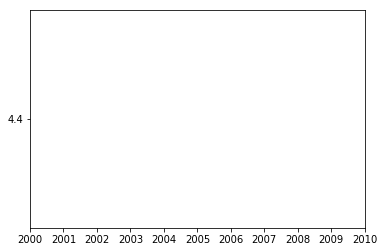

In [19]:
#Describe what happens when the button changes its value
button = widgets.Button(description="Plot graph")
display(button)



def on_button_clicked(b):
    print("Button clicked.")
    #populate y values
    print('x: %s, y:%s' % (xaxisfield, yaxisfield))
    if (xaxisfield == '' 
        or xaxisfield == 'Choose Field'
        or yaxisfield == ''
        or yaxisfield == 'Choose Variable:'):
        print('Select x and y axis variables before clicking the plot graph button')
        return
    
    if (yaxisfield in df.columns):
        ydata=df[yaxisfield]
    else:
        print('y axis selector: '+ yaxisfield)
        ydata=df.loc[df['parm_cd'] == yaxisfield]['result_va']
        
    print( ydata)
    try:
        df.sort_values(xaxisfield, ascending=True)
        plt.plot(df[xaxisfield], ydata)
        xlabel('Time(years)')
        title(getmetavalue(datalist, str(yaxisfield)))
    except ValueError:
        print('The column contains a Non-Integer Value! Nothing Can be Displayed!')
    
    return
    
    #print('change: ' + str(change))
    #if change['type'] == 'change' and change['name'] == 'value':
    #    try:
    #        df.sort_values('sample_dt', ascending=True)
    #        plt.plot(df['sample_dt'], df[change['new']])
    #        xlabel('Time(years)')
    #        title(change['new'])
    #    except ValueError:
    #        print('The column contains a Non-Integer Value! Nothing Can be Displayed!')

    
button.on_click(on_button_clicked)

In [ ]:
#from tqdm import tqdm
#for i in tqdm(range(10000)):